In [2]:
import numpy as np
import networkx as nx
import copy
import matplotlib.pyplot as plt
import time

%matplotlib inline

In [3]:
N_NODES = 200
SPECT_RADIUS = 0.98

In [4]:
def correct_dimensions(s, targetlength):
    if s is not None:
        s = np.array(s)
        if s.ndim == 0:
            s = np.array([s] * targetlength)
        elif s.ndim == 1:
            if not len(s) == targetlength:
                raise ValueError("arg must have length " + str(targetlength))
        else:
            raise ValueError("Invalid argument")
    return s


def identity(x):
    return x

def step_function(x):
    if x > 0.5:
        return 1
    else:
        return 0
    
def sigmoid(x):
    return 1/(1+np.exp(-10*x+1))


class LI_ESN_internal:

    def __init__(self, n_inputs, n_outputs, n_reservoir=200, W=None, W_in=None,
                 noise=0.001, input_shift=None,
                 input_scaling=None, feedback_scaling=None,
                 teacher_scaling=None, teacher_shift=None,
                 out_activation=identity, inverse_out_activation=identity,
                 random_state=None, time_scale=None):
        # check for proper dimensionality of all arguments and write them down.
        self.n_inputs = n_inputs
        self.n_reservoir = n_reservoir
        self.n_outputs = n_outputs
        self.noise = noise
        self.input_shift = correct_dimensions(input_shift, n_inputs)
        self.input_scaling = correct_dimensions(input_scaling, n_inputs)

        self.teacher_scaling = teacher_scaling
        self.teacher_shift = teacher_shift

        self.out_activation = out_activation
        self.inverse_out_activation = inverse_out_activation
        self.random_state = random_state
        self.time_scale = time_scale
        self.W = W
        self.W_in = W_in

        # the given random_state might be either an actual RandomState object,
        # a seed or None (in which case we use numpy's builtin RandomState)
        if isinstance(random_state, np.random.RandomState):
            self.random_state_ = random_state
        elif random_state:
            try:
                self.random_state_ = np.random.RandomState(random_state)
            except TypeError as e:
                raise Exception("Invalid seed: " + str(e))
        else:
            self.random_state_ = np.random.mtrand._rand
            
    def _scale_inputs(self, inputs):
        """for each input dimension j: multiplies by the j'th entry in the
        input_scaling argument, then adds the j'th entry of the input_shift
        argument."""
        if self.input_scaling is not None:
            inputs = np.dot(inputs, np.diag(self.input_scaling))
        if self.input_shift is not None:
            inputs = inputs + self.input_shift
        return inputs

    def _update(self, state, input_pattern):
        # leaky integrator model:
        # it can adjust timescales for each neurons.
        preactivation = (np.dot(self.W, state) + np.dot(self.W_in, input_pattern))
        state = (1 - self.time_scale) * state + self.time_scale * np.tanh(preactivation)
        # state = (1 - self.time_scale) * state + self.time_scale * preactivation
        return (state + self.noise * self.time_scale * (self.random_state_.rand(self.n_reservoir) - 0.5))

    def calc_lyapunov_exp(self, inputs, initial_distance, n):
        if inputs.ndim < 2:
            inputs = np.reshape(inputs, (len(inputs), -1))
        states1 = np.zeros((inputs.shape[0], self.n_reservoir))
        states2 = np.zeros((inputs.shape[0], self.n_reservoir))
        transient = min(int(inputs.shape[0] / 10), 100)
        for i in range(1, transient):
            states1[i, :] = self._update(states1[i-1], inputs[i, :])
        states2[transient-1, :] = states1[transient-1, :]
        states2[transient-1, n] = states2[transient-1, n] + initial_distance
        gamma_k_list = []
        for k in range(transient, inputs.shape[0]):
            states1[k, :] = self._update(states1[k-1], inputs[k, :])
            states2[k, :] = self._update(states2[k-1], inputs[k, :])
            gamma_k = np.linalg.norm(states2[k, :]-states1[k, :])
            gamma_k_list.append(gamma_k/initial_distance)
            states2[k, :] = states1[k, :] + (initial_distance/gamma_k)*(states2[k, :]-states1[k, :])
        lyapunov_exp = np.mean(np.log(gamma_k_list))
        return lyapunov_exp
            
    
    def fit(self, inputs, outputs):
        if inputs.ndim < 2:
            inputs = np.reshape(inputs, (len(inputs), -1))
        if outputs.ndim < 2:
            outputs = np.reshape(outputs, (len(outputs), -1))
        inputs_scaled = self._scale_inputs(inputs)
        teachers_scaled = outputs

        # step the reservoir through the given input,output pairs:
        self.states = np.zeros((inputs.shape[0], self.n_reservoir))
        # self.states[0] = np.random.rand(self.n_reservoir)*2-1
        for n in range(1, inputs.shape[0]):
            self.states[n, :] = self._update(self.states[n - 1], inputs_scaled[n, :])
        transient = min(int(inputs.shape[0] / 10), 100)
        extended_states = np.hstack((self.states, inputs_scaled))
        
        self.W_out = np.dot(np.linalg.pinv(extended_states[transient:, :]),teachers_scaled[transient:, :]).T
        # print(self.W_out.shape)

        # remember the last state for later:
        self.laststate = self.states[-1, :]
        self.lastinput = inputs[-1, :]
        self.lastoutput = teachers_scaled[-1, :]
            
        # apply learned weights to the collected states:
        pred_train = np.dot(extended_states, self.W_out.T)
        return pred_train

    def predict(self, inputs, continuation=True):
        if inputs.ndim < 2:
            inputs = np.reshape(inputs, (len(inputs), -1))
        n_samples = inputs.shape[0]

        if continuation:
            laststate = self.laststate
            lastinput = self.lastinput
            lastoutput = self.lastoutput
        else:
            laststate = np.zeros(self.n_reservoir)
            lastinput = np.zeros(self.n_inputs)
            lastoutput = np.zeros(self.n_outputs)

        inputs = np.vstack([lastinput, inputs])
        states = np.vstack(
            [laststate, np.zeros((n_samples, self.n_reservoir))])
        outputs = np.vstack(
            [lastoutput, np.zeros((n_samples, self.n_outputs))])

        for n in range(n_samples):
            states[n + 1, :] = self._update(states[n, :], inputs[n + 1, :])
            outputs[n + 1, :] = np.dot(self.W_out,np.concatenate([states[n + 1, :], inputs[n + 1, :]]))

        return self.out_activation(outputs[1:])
        # print(outputs[1:])
        # return np.heaviside(outputs[1:]-0.5, 0)*0.3


In [5]:
def make_layered_network(N, average_degree, community_number, mu):
    assert N % community_number == 0, 'N must be devisible by community_number'
    size = N/community_number
    G = np.zeros((N, N))
    for i in range(N):
        com_index = i//size
        for j in range(N):
            if j <= size*(com_index+1) and j >= size*com_index:
                if i != j and np.random.rand() < average_degree*(1-1*mu)/(size-1):
                    G[i][j] = np.random.randn()
            elif j >= size*(com_index-1) and j <= size*(com_index+1):
                if np.random.rand() < average_degree*mu/size:
                    G[i][j] = np.random.randn()
                    
    return G

In [41]:
average_degree=40
num_community=4
mu=0.35

intri_ts1 = []
intri_ts2 = []
intri_ts3 = []

start = time.time()

for trial in range(500):
    sin_like_sequence = np.zeros((10, 5000))

    for i in range(10):
        x = np.arange(0, 250, 0.05)
        sin_like_sequence[i] = (np.random.rand(5000)*2-1)

    sin_like_sequence_T = sin_like_sequence.T

    community_size = N_NODES//num_community
    time_scale = np.ones(N_NODES)*0.5

    W = make_layered_network(N_NODES, average_degree, num_community, mu)
    W_IN = (np.random.rand(N_NODES, 10) * 2 - 1)*0.1
    W_IN[int(N_NODES/num_community):] = 0
    radius = np.max(np.abs(np.linalg.eigvals(W)))
    spectral_radius = SPECT_RADIUS
    W = W * (spectral_radius / radius)

    esn = LI_ESN_internal(n_inputs=10,
                          n_outputs=1,
                          n_reservoir=N_NODES,
                          W=W,
                          W_in=W_IN,
                          noise=0,
                          time_scale=time_scale)

    _ = esn.fit(sin_like_sequence_T, np.random.rand(5000))
    states = esn.states
    
        
    autocorrelation_list = np.zeros((30,community_size))
    for i in range(community_size):
        for j in range(30):
            autocorrelation_list[j][i] = np.corrcoef(states.T[community_size+i][101+j:4001+j], states.T[community_size+i][100:4000])[0][1]
    autocorrelation_mean_std_com1 = np.zeros((2, 30))
    for i in range(30):
        autocorrelation_mean_std_com1[0][i] = np.mean(autocorrelation_list[i])
        autocorrelation_mean_std_com1[1][i] = np.std(autocorrelation_list[i])
    # plt.plot(autocorrelation_mean_std_com1[0])
    
    autocorrelation_list = np.zeros((30,community_size))
    for i in range(community_size):
        for j in range(30):
            autocorrelation_list[j][i] = np.corrcoef(states.T[community_size*2+i][101+j:4001+j], states.T[community_size*2+i][100:4000])[0][1]
    autocorrelation_mean_std_com2 = np.zeros((2, 30))
    for i in range(30):
        autocorrelation_mean_std_com2[0][i] = np.mean(autocorrelation_list[i])
        autocorrelation_mean_std_com2[1][i] = np.std(autocorrelation_list[i])
    # plt.plot(autocorrelation_mean_std_com2[0])
    
    autocorrelation_list = np.zeros((30,community_size))
    for i in range(community_size):
        for j in range(30):
            autocorrelation_list[j][i] = np.corrcoef(states.T[community_size*3+i][101+j:4001+j], states.T[community_size*3+i][100:4000])[0][1]
    autocorrelation_mean_std_com3 = np.zeros((2, 30))
    for i in range(30):
        autocorrelation_mean_std_com3[0][i] = np.mean(autocorrelation_list[i])
        autocorrelation_mean_std_com3[1][i] = np.std(autocorrelation_list[i])
    # plt.plot(autocorrelation_mean_std_com3[0])
    
    ts1 = np.mean(np.diff(autocorrelation_mean_std_com1[0][:10], 1))
    ts2 = np.mean(np.diff(autocorrelation_mean_std_com2[0][:10], 1))
    ts3 = np.mean(np.diff(autocorrelation_mean_std_com3[0][:10], 1))
    print(trial, ts1, ts2, ts3)
    # print(np.mean(np.diff(autocorrelation_mean_std_com2[0][:10], 1)))
    # print(np.mean(np.diff(autocorrelation_mean_std_com3[0][:10], 1)))
    intri_ts1.append(ts1)
    intri_ts2.append(ts2)
    intri_ts3.append(ts3)

end = time.time()
print(end-start)

0 -0.09693551044861842 -0.08310950379707098 -0.0700891421696663
1 -0.07995506787161188 -0.0482347018101423 -0.03954710274846059
2 -0.10733898249870479 -0.08632586998639227 -0.08002510605867381
3 -0.09641831036553573 -0.09298344049201619 -0.09692247943093794
4 -0.09811752995016204 -0.10455970602053871 -0.09830578546353036
5 -0.0839931232602516 -0.04947359195173118 -0.047171644343129114
6 -0.09295729098100064 -0.08811219748136473 -0.08011116510448597
7 -0.07935649454057722 -0.06372921984407223 -0.05566509717189708
8 -0.09141909736355731 -0.0561940122586105 -0.05166161889143287
9 -0.08064864595013681 -0.09771955948811427 -0.10482250590596646
10 -0.095618340337779 -0.09746614887065269 -0.08408044919211818
11 -0.08597820463796164 -0.08972967022921935 -0.08333843103165678
12 -0.09208030177557193 -0.09400654555142547 -0.06781520480424721
13 -0.09077974202145783 -0.08295186515435378 -0.08329028833156611
14 -0.08180348870064308 -0.08092594592148128 -0.07159588322375326
15 -0.08873129592781953 -

125 -0.0750383942911177 -0.07092656071201447 -0.06464074359326523
126 -0.08350451967977016 -0.06600142330461993 -0.060118303310637736
127 -0.09184656316786514 -0.06585479632103618 -0.055026139027814974
128 -0.09284344230705786 -0.09403315028927062 -0.0813340452960635
129 -0.09115489699964435 -0.09070481946686908 -0.08835899551571832
130 -0.05257675834768649 -0.06209951142754871 -0.04420133660930333
131 -0.0769725477549711 -0.0851291114032694 -0.07259842932617616
132 -0.06197335190979109 -0.041480460331059864 -0.03756708589689189
133 -0.10092929768216906 -0.09639371122985409 -0.08705673528537212
134 -0.107724040399718 -0.10791875932219823 -0.06334233989532377
135 -0.04927906564782008 -0.030082421982998882 -0.02620330104511474
136 -0.09035224214782915 -0.08686456244880209 -0.06603510923717115
137 -0.10194946137386632 -0.10122917348331154 -0.0930310929182056
138 -0.09979185993000066 -0.1021605216038344 -0.09932804045613218
139 -0.11426819584981891 -0.12038275138909985 -0.1117557120263328


248 -0.07153891849160608 -0.06790353892244472 -0.05368251710258994
249 -0.08681617525097388 -0.08951723554745614 -0.07076757585850427
250 -0.07438755402747896 -0.057676091237944135 -0.03447108778205554
251 -0.10161031270025898 -0.09337300008722929 -0.08466260574358886
252 -0.0953653941622087 -0.10174471480077714 -0.09619771646488386
253 -0.09595547575693732 -0.09038473661116632 -0.06943218480370433
254 -0.08792034561206585 -0.0884747714920871 -0.0806049011799772
255 -0.09442337556174052 -0.07921829883235579 -0.06707858954065854
256 -0.09329986612926114 -0.09248284389123157 -0.0943867461083979
257 -0.039236341660426714 -0.016044081743998455 -0.01877510515788668
258 -0.09076667469300156 -0.06300480251456188 -0.05468735946351761
259 -0.10626985963605445 -0.09226731880129208 -0.08322669202063888
260 -0.09713575151557213 -0.09663764610948393 -0.0727501644113269
261 -0.07791831591505925 -0.05190652079003376 -0.04570929491666509
262 -0.09279700943656721 -0.09711996355587556 -0.091069058845470

371 -0.08336933427450396 -0.07149558248332347 -0.06902500203404183
372 -0.06358667211311768 -0.07336269775141607 -0.048738897771607656
373 -0.09514643706462259 -0.08624192209630817 -0.081147490583902
374 -0.08497881236351207 -0.08110091080480357 -0.056460110580995884
375 -0.05189441533543392 -0.05009083049248887 -0.038386212313733084
376 -0.08956526513960456 -0.08569270156496296 -0.07389427483937494
377 -0.10726036079819648 -0.10841938623971567 -0.10875995051792797
378 -0.094890766872173 -0.10029253169759944 -0.09757679011356704
379 -0.06502465397476857 -0.05278577147858248 -0.04663124954162141
380 -0.10464019208468692 -0.11706848191749485 -0.08846343055936265
381 -0.0863680346804447 -0.07603152904651174 -0.06555596227437564
382 -0.09685959091511026 -0.09188378315673627 -0.047389518917663506
383 -0.033457618136779596 -0.0355050852777365 -0.0255735755209464
384 -0.06701679200754426 -0.06196610494304374 -0.03490593884276331
385 -0.09107967274762971 -0.1009904905205194 -0.0794127762409229

494 -0.10128316695582405 -0.1057732124885822 -0.10003032408376933
495 -0.09211716044548057 -0.08279650827008138 -0.07769723629378417
496 -0.11512495054791011 -0.10908743882615579 -0.09473907530681734
497 -0.07934076437438192 -0.0668382066516569 -0.06172984234245076
498 -0.07168262050554802 -0.06065216830006855 -0.05735560610524009
499 -0.08502011281175006 -0.08720106317025225 -0.07946566841464368
386.8017454147339


In [42]:
intrinsic_timescale = np.vstack((np.array(intri_ts1), np.array(intri_ts2), np.array(intri_ts3)))
diff_1_2 = [np.diff(intrinsic_timescale.T[i])[0] for i in range(500)]
diff_2_3 = [np.diff(intrinsic_timescale.T[i])[1] for i in range(500)]
print(np.mean(intri_ts1),'\t',  np.std(intri_ts1), '\t', np.mean(intri_ts2), '\t', np.std(intri_ts2), '\t', np.mean(intri_ts3), '\t', np.std(intri_ts3),
     '\t', np.mean(diff_1_2), '\t', np.std(diff_1_2), '\t', np.mean(diff_2_3), '\t', np.std(diff_2_3))


-0.08646329728344036 	 0.013879591190549118 	 -0.07923942048065558 	 0.01926611235748292 	 -0.0707002406457845 	 0.021199945061775156 	 0.007223876802784772 	 0.013036303798859908 	 0.008539179834871085 	 0.01043649094389261


In [1428]:
intrinsic_timescale = np.vstack((np.array(intri_ts1), np.array(intri_ts2), np.array(intri_ts3)))
diff_1_2 = [np.diff(intrinsic_timescale.T[i])[0] for i in range(500)]
diff_2_3 = [np.diff(intrinsic_timescale.T[i])[1] for i in range(500)]

In [1410]:
print(np.mean(diff_1_2))
print(np.mean(diff_2_3))
print(np.std(diff_1_2))
print(np.std(diff_2_3))

0.008507268263299582
0.009672707186319733
0.013955413677264574
0.013595698256826117


In [1373]:
sin_like_sequence = np.zeros((10, 5000))

for i in range(10):
    x = np.arange(0, 250, 0.05)
    scale = np.random.rand()
    # sin_like_sequence[i] = np.sin((i+1)*x)*scale+(np.random.rand(5000)*2-1)*0.1
    # sin_like_sequence[i] = [scale for i in x]
    # sin_like_sequence[i] = np.array(sin_like_sequence[i])
    sin_like_sequence[i] = (np.random.rand(5000)*2-1)
# sequence_p = copy.deepcopy(sequence_u)
sin_like_sequence_T = sin_like_sequence.T

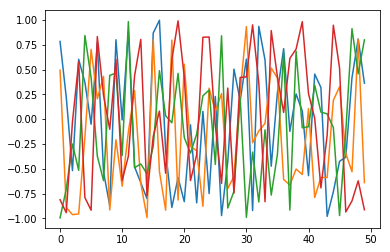

In [1374]:
plt.plot(sin_like_sequence[2][:50])
plt.plot(sin_like_sequence[1][:50])
plt.plot(sin_like_sequence[5][:50])
plt.plot(sin_like_sequence[3][:50])

In [11]:
average_degree=80
num_community=4
mu=0.2
community_size = N_NODES//num_community
time_scale = np.ones(N_NODES)*0.5
# time_scale[11] = 0.01
# for i in range(num_community):
#     time_scale[i*community_size: (i+1)*community_size] = 1 - i/num_community

# G = nx.generators.barabasi_albert_graph(N_NODES, 10)
# W = nx.to_numpy_array(G)


W = make_layered_network(N_NODES, average_degree, num_community, mu)
# W = np.random.randn(N_NODES, N_NODES)
# time_scale[2*community_size: 3*community_size] = 0.05
# W = generate_networks.make_modular_network(N_NODES,20, 4, 0.2)
# W = generate_networks.make_recurrent_layered_network(N_NODES, 20, 4, mu)
W_IN = (np.random.rand(N_NODES, 10) * 2 - 1)*0.1
W_IN[int(N_NODES/num_community):] = 0
radius = np.max(np.abs(np.linalg.eigvals(W)))
spectral_radius = SPECT_RADIUS
W = W * (spectral_radius / radius)
# print(time_scale)

esn = LI_ESN_internal(n_inputs=10,
                      n_outputs=1,
                      n_reservoir=N_NODES,
                      W=W,
                      W_in=W_IN,
                      noise=0,
                      time_scale=time_scale)

_ = esn.fit(sin_like_sequence_T, np.random.rand(5000))
states = esn.states


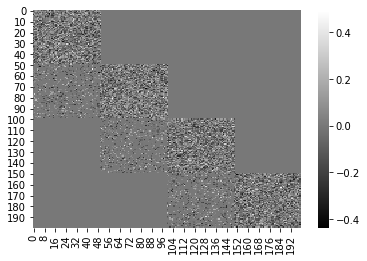

In [12]:
import seaborn as sns
sns.heatmap(W, cmap='gray')

In [1379]:
print(states.shape)

(5000, 200)


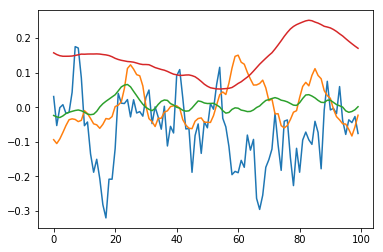

In [1380]:
plt.plot(states.T[0][1000:1100])
plt.plot(states.T[60][1000:1100])
plt.plot(states.T[100][1000:1100])
plt.plot(states.T[170][1000:1100])

In [1381]:
"""
plt.plot(states.T[0][1000:])
plt.plot(states.T[26][1000:])
plt.plot(states.T[60][1000:])
plt.plot(states.T[98][1000:])
"""

'\nplt.plot(states.T[0][1000:])\nplt.plot(states.T[26][1000:])\nplt.plot(states.T[60][1000:])\nplt.plot(states.T[98][1000:])\n'

In [1382]:
print(community_size)

50


In [1383]:
autocorrelation_list = np.zeros((30,community_size))
for i in range(community_size):
    for j in range(30):
        autocorrelation_list[j][i] = np.corrcoef(states.T[i][101+j:4001+j], states.T[i][100:4000])[0][1]
autocorrelation_mean_std_com0 = np.zeros((2, 30))
for i in range(30):
    autocorrelation_mean_std_com0[0][i] = np.mean(autocorrelation_list[i])
    autocorrelation_mean_std_com0[1][i] = np.std(autocorrelation_list[i])


(30, 50)


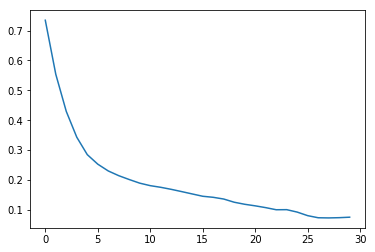

In [1384]:
print(autocorrelation_list.shape)
plt.plot(autocorrelation_mean_std_com0[0])

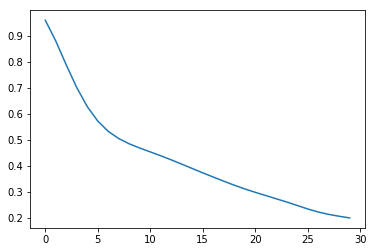

In [1385]:
autocorrelation_list = np.zeros((30,community_size))
for i in range(community_size):
    for j in range(30):
        autocorrelation_list[j][i] = np.corrcoef(states.T[community_size+i][101+j:4001+j], states.T[community_size+i][100:4000])[0][1]
autocorrelation_mean_std_com1 = np.zeros((2, 30))
for i in range(30):
    autocorrelation_mean_std_com1[0][i] = np.mean(autocorrelation_list[i])
    autocorrelation_mean_std_com1[1][i] = np.std(autocorrelation_list[i])
plt.plot(autocorrelation_mean_std_com1[0])

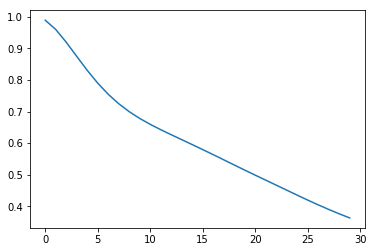

In [1386]:
autocorrelation_list = np.zeros((30,community_size))
for i in range(community_size):
    for j in range(30):
        autocorrelation_list[j][i] = np.corrcoef(states.T[community_size*2+i][101+j:4001+j], states.T[community_size*2+i][100:4000])[0][1]
autocorrelation_mean_std_com2 = np.zeros((2, 30))
for i in range(30):
    autocorrelation_mean_std_com2[0][i] = np.mean(autocorrelation_list[i])
    autocorrelation_mean_std_com2[1][i] = np.std(autocorrelation_list[i])
plt.plot(autocorrelation_mean_std_com2[0])

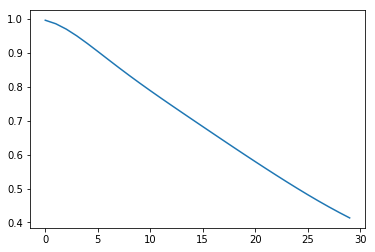

In [1387]:
autocorrelation_list = np.zeros((30,community_size))
for i in range(community_size):
    for j in range(30):
        autocorrelation_list[j][i] = np.corrcoef(states.T[community_size*3+i][101+j:4001+j], states.T[community_size*3+i][100:4000])[0][1]
autocorrelation_mean_std_com3 = np.zeros((2, 30))
for i in range(30):
    autocorrelation_mean_std_com3[0][i] = np.mean(autocorrelation_list[i])
    autocorrelation_mean_std_com3[1][i] = np.std(autocorrelation_list[i])
plt.plot(autocorrelation_mean_std_com3[0])

<Container object of 3 artists>

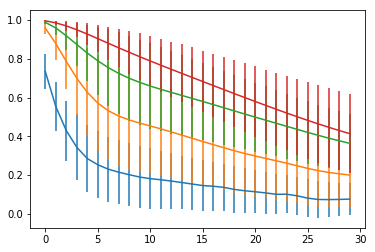

In [1388]:
x = np.arange(0, 30)
plt.errorbar(x, autocorrelation_mean_std_com0[0], autocorrelation_mean_std_com0[1])
plt.errorbar(x, autocorrelation_mean_std_com1[0], autocorrelation_mean_std_com1[1])
plt.errorbar(x, autocorrelation_mean_std_com2[0], autocorrelation_mean_std_com2[1])
plt.errorbar(x, autocorrelation_mean_std_com3[0], autocorrelation_mean_std_com3[1])

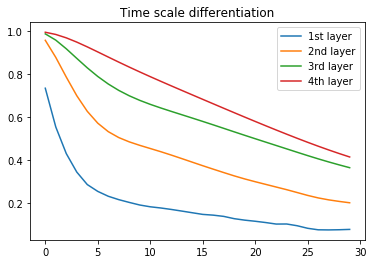

In [1389]:
x = np.arange(0, 30)
plt.plot(x, autocorrelation_mean_std_com0[0], label='1st layer')
plt.plot(x, autocorrelation_mean_std_com1[0], label='2nd layer')
plt.plot(x, autocorrelation_mean_std_com2[0], label='3rd layer')
plt.plot(x, autocorrelation_mean_std_com3[0], label='4th layer')
plt.title('Time scale differentiation')
plt.legend()
plt.show()

In [1390]:
# np.diff(autocorrelation_mean_std_com3[0][:10], 1)
# print(np.mean(np.diff(autocorrelation_mean_std_com0[0][:10], 1)))
print(np.mean(np.diff(autocorrelation_mean_std_com1[0][:10], 1)))
print(np.mean(np.diff(autocorrelation_mean_std_com2[0][:10], 1)))
print(np.mean(np.diff(autocorrelation_mean_std_com3[0][:10], 1)))

-0.054545139877530166
-0.034526921472904336
-0.020605652787062598


In [1298]:
print(np.corrcoef(states.T[0][101:4001], states.T[0][100:4000])[0][1])
print(np.corrcoef(states.T[0][102:4002], states.T[0][100:4000])[0][1])
print(np.corrcoef(states.T[0][103:4003], states.T[0][100:4000])[0][1])
print(np.corrcoef(states.T[0][104:4004], states.T[0][100:4000])[0][1])
print(np.corrcoef(states.T[0][105:4005], states.T[0][100:4000])[0][1])
print(np.corrcoef(states.T[0][106:4006], states.T[0][100:4000])[0][1])
print(np.corrcoef(states.T[0][107:4007], states.T[0][100:4000])[0][1])
print(np.corrcoef(states.T[0][108:4008], states.T[0][100:4000])[0][1])
print(np.corrcoef(states.T[0][109:4009], states.T[0][100:4000])[0][1])
print(np.corrcoef(states.T[0][110:4010], states.T[0][100:4000])[0][1])
print(np.corrcoef(states.T[0][111:4011], states.T[0][100:4000])[0][1])

0.5282113846013478
0.25818284972775124
0.11522747985597907
0.03181899859740549
0.022229072379531437
0.05071843809352943
0.0654659787019261
0.08627501434556732
0.08155701869353363
0.04394169293691907
0.016540134916803093


In [620]:
print(np.corrcoef(states.T[11][101:4001], states.T[11][100:4000])[0][1])
print(np.corrcoef(states.T[11][102:4002], states.T[11][100:4000])[0][1])
print(np.corrcoef(states.T[11][103:4003], states.T[11][100:4000])[0][1])
print(np.corrcoef(states.T[11][104:4004], states.T[11][100:4000])[0][1])
print(np.corrcoef(states.T[11][105:4005], states.T[11][100:4000])[0][1])
print(np.corrcoef(states.T[11][106:4006], states.T[11][100:4000])[0][1])
print(np.corrcoef(states.T[11][107:4007], states.T[11][100:4000])[0][1])
print(np.corrcoef(states.T[11][108:4008], states.T[11][100:4000])[0][1])
print(np.corrcoef(states.T[11][109:4009], states.T[11][100:4000])[0][1])
print(np.corrcoef(states.T[11][110:4010], states.T[11][100:4000])[0][1])
print(np.corrcoef(states.T[11][111:4011], states.T[11][100:4000])[0][1])

0.9759472651305887
0.9066792081761217
0.7977844327653115
0.6579081717715276
0.49778007810050107
0.3291713182485458
0.16367932541915725
0.011885681251942492
-0.11763120148665883
-0.21875643262759933
-0.2881322551284281


In [621]:
print(np.corrcoef(states.T[12][101:4001], states.T[12][100:4000])[0][1])
print(np.corrcoef(states.T[12][102:4002], states.T[12][100:4000])[0][1])
print(np.corrcoef(states.T[12][103:4003], states.T[12][100:4000])[0][1])
print(np.corrcoef(states.T[12][104:4004], states.T[12][100:4000])[0][1])
print(np.corrcoef(states.T[12][105:4005], states.T[12][100:4000])[0][1])
print(np.corrcoef(states.T[12][106:4006], states.T[12][100:4000])[0][1])
print(np.corrcoef(states.T[12][107:4007], states.T[12][100:4000])[0][1])
print(np.corrcoef(states.T[12][108:4008], states.T[12][100:4000])[0][1])
print(np.corrcoef(states.T[12][109:4009], states.T[12][100:4000])[0][1])
print(np.corrcoef(states.T[12][110:4010], states.T[12][100:4000])[0][1])
print(np.corrcoef(states.T[12][111:4011], states.T[12][100:4000])[0][1])

0.9562722194872757
0.8438260677709647
0.6796372257331971
0.48878597888312586
0.30061782107338963
0.1427835085553557
0.037332322370763525
-0.0034999935369705595
0.0212492718238213
0.10065620665906215
0.2148346566883712


In [52]:
print(np.corrcoef(states.T[260][101:4001], states.T[260][100:4000])[0][1])
print(np.corrcoef(states.T[260][102:4002], states.T[260][100:4000])[0][1])
print(np.corrcoef(states.T[260][103:4003], states.T[260][100:4000])[0][1])
print(np.corrcoef(states.T[260][104:4004], states.T[260][100:4000])[0][1])
print(np.corrcoef(states.T[260][105:4005], states.T[260][100:4000])[0][1])

IndexError: index 260 is out of bounds for axis 0 with size 100

In [334]:
print(np.corrcoef(states.T[600][101:4001], states.T[600][100:4000])[0][1])
print(np.corrcoef(states.T[600][102:4002], states.T[600][100:4000])[0][1])
print(np.corrcoef(states.T[600][103:4003], states.T[600][100:4000])[0][1])
print(np.corrcoef(states.T[600][104:4004], states.T[600][100:4000])[0][1])
print(np.corrcoef(states.T[600][105:4005], states.T[600][100:4000])[0][1])

0.8700677878899802
0.5283677936036678
0.09526935925380095
-0.2910327202537867
-0.5279817930138296


In [335]:
print(np.corrcoef(states.T[980][101:4001], states.T[980][100:4000])[0][1])
print(np.corrcoef(states.T[980][102:4002], states.T[980][100:4000])[0][1])
print(np.corrcoef(states.T[980][103:4003], states.T[980][100:4000])[0][1])
print(np.corrcoef(states.T[980][104:4004], states.T[980][100:4000])[0][1])
print(np.corrcoef(states.T[980][105:4005], states.T[980][100:4000])[0][1])

0.9902169322518115
0.9624720492301513
0.9208776933687677
0.8703657544469511
0.8151308708102721


In [24]:
np.correlate(sin_like_sequence[2][3:103], sin_like_sequence[2][:100])

array([9.12388533])

In [25]:
np.correlate(sin_like_sequence[2][3:103]*2, sin_like_sequence[2][:100]*2)

array([36.49554133])

In [ ]:
def measure_intrinsic_timescale(sequence1, sequence2):
    